# Note on Gridworld Action Space Restriction
There is a problem, potentially, since staying in a location is not an allowable action (technically) but an agent could repeatedly choose an invalid action (if the invalid action is selectable in the first place). So I need to further prune the set of actions, depending on the state, but I do not want to do so in a way that is manual.

The way to do this is to count the number of non-corner edge states and account for that in the allowable set of actions. Since the area of the grid is length^2, the perimeter is 4$*$length, and the number of non-corner edge states is therefore 4$*$(length-1) and the number of corners is 4. Therefore, the number of allowable actions (dependent on state) is: $\left(4*{length}^2-4*length\right)*4+4*(length-1)*3+4*2$ so for $length=5$ we have $(100-20)*4+16*3+8=320+48+8=376$ actions.

## SARSA Implementation
To enable graphical output, have the render_init variable = 't' on line 121

In [ ]:
a = 1
b = 2
c = 3
if (a == 1 and b == 1) and c == 3:
    print('test')

In [21]:
import numpy as np
a = np.array([[1,2],[3,0]])
print(np.flipud(a))
#np.array([[-1,-1,-1,-1,-1,-1,-1],[-1, 0, 10, 0, 5, 0, -1]])
b=np.array([ [-1,-1,-1,-1,-1,-1,-1],[-1, 0, 10, 0, 5, 0, -1],[-1, 0, 0, 0, 0, 0, -1],\
    [-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, -1, -1, -1, -1, -1, -1] ]) 
c = np.flipud(b)
print(c)
print(b[1,2])
print(b[:,0::6])

[[3 0]
 [1 2]]
[[-1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0 -1]
 [-1  0  0  0  0  0 -1]
 [-1  0  0  0  0  0 -1]
 [-1  0  0  0  0  0 -1]
 [-1  0 10  0  5  0 -1]
 [-1 -1 -1 -1 -1 -1 -1]]
10
[[-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]]


<IPython.core.display.Javascript object>


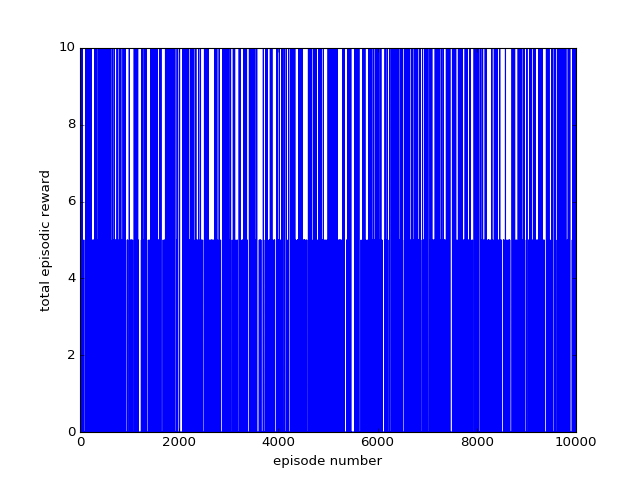

[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  10.   0.   5.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]
[[ 0.99775375  0.5323524   0.31438718  0.32464308  0.98395468]
 [ 0.09018852  0.67011955  0.58929653  0.677836    0.79443145]
 [ 0.19938715  0.03112198  0.30644933  0.48196687  0.47497063]
 [ 0.41354928  0.34738553  0.27098751  0.14914135  0.45672261]
 [ 0.69573731  0.61524466  0.24442025  0.35376131  0.56208015]]
[[ 0.95518339  0.91091723  0.70636012  0.04110693  0.59799354]
 [ 0.72321372  0.45112913  0.82970744  0.54882367  0.52530265]
 [ 0.2377341   0.13525949  0.19721436  0.42968184  0.44755743]
 [ 0.6751485   0.92190352  0.85667309  0.01751567  0.69009233]
 [ 0.46233709  0.50686468  0.73977463  0.03968652  0.15114643]]
[[ 0.47337121  0.98325889  0.99369238  0.97328836  0.92107966]
 [ 0.0552192   0.53862097  0.1586651  

In [103]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.ticker as plticker

class gridworld(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self): 
    self.render_label = 'f'
    self.gridnum = int(7) #size of gridworld
    self.location_x = np.random.randint(int(1),self.gridnum-1)
    self.location_y = np.random.randint(int(1),self.gridnum-1)
    self.action = int(0) # no initial action until computed
    self.previous_action = self.action
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.allowed_actions = np.array([1,2,3,4])[np.newaxis]
    self.actionSet = np.matrix([1,2,3,4])
    self.episode_length = int(100)
    self.num_episodes = int(10000) # currently only running one episode, 10000
    self.my_alpha = 0.1
    self.my_gamma = 0.9
    self.my_epsilon = 0.1
    self.my_reward =np.array([ [-1,-1,-1,-1,-1,-1,-1],[-1, 0, 10, 0, 5, 0, -1],[-1, 0, 0, 0, 0, 0, -1],\
    [-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, 0, 0, 0, 0, 0, -1],[-1, -1, -1, -1, -1, -1, -1] ]) 
    self.my_reward = np.flipud(self.my_reward)
    self.my_reward_model = np.zeros([self.gridnum,self.gridnum])#reward model updated based on observations
    self.my_q_function = np.random.rand(self.gridnum,self.gridnum, int(4))# randomly initialized via reward model
    self.my_q_function[0::6,:,:] = 0# to prevent biasing agent with favorable "out of bound" q functions
    self.my_q_function[:,0::6,:] = 0# to prevent biasing agent with favorable "out of bound" q functions
    self.my_reward_log = np.random.rand(1, self.episode_length*self.num_episodes) # used to store reward for each time step
    self.my_episodic_cumulative_reward_log = np.random.rand(1,self.num_episodes)
    pass
  def my_policy(self):
    if (self.previous_x != self.location_x and self.previous_y != self.location_y)\
    or (self.previous_previous_x != self.previous_x and self.previous_previous_y != self.previous_y):
        self.previous_action = self.action # still want this because the agent selected a poor action and should evaluate it
    self.action = self.allowed_actions[0,\
    np.argmax(self.my_q_function[self.location_x,self.location_y,self.allowed_actions-1])]
    if np.random.rand() <= self.my_epsilon:
        self.action = self.allowed_actions[0,np.random.randint(0,self.allowed_actions.shape[1])]
    pass
  def render(self,fig,ax): #mode='human', close=False <- no idea what this is for
    ax = fig.gca()    
    ax.clear()
    ax.grid(which='major', axis='both', linestyle='-')
    circle2 = plt.Circle((world.location_x+0.5, world.location_y+0.5), 0.5, color='blue')#rand initialization
    ax.add_artist(circle2)
    fig.canvas.draw()
    pass
  def render_init(self):
    fig, (ax)=plt.subplots()
    intervals = float(1/world.gridnum)# dimension of grid affects size
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.set_xlim(0, world.gridnum)
    ax.yaxis.set_major_locator(loc)
    ax.set_ylim(0, world.gridnum)
    return fig, ax
  def reset(self):
    self.location_x = np.random.randint(int(1),self.gridnum-1)
    self.location_y = np.random.randint(int(1),self.gridnum-1)
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    pass
  def step(self):
    self.previous_previous_x = self.previous_x
    self.previous_previous_y = self.previous_y
    self.previous_x = self.location_x# only accurate for second step in episode
    self.previous_y = self.location_y# only accurate for second step in episode
    desired_action = self.action
    if np.random.rand() <= 0.1: # this part of the method is to enforce a 10% chance of a random transition
        self.action = self.allowed_actions[0,np.random.randint(1,self.allowed_actions.shape[1])]
    if self.action == 1: # this part of the method is to select the desired deterministic action
        self.location_y += 1
    elif self.action == 2:
        self.location_y += -1
    elif self.action == 3:
        self.location_x += -1
    elif self.action == 4:
        self.location_x += 1
    self.action = desired_action# reports selected action, but has the agent move according to transition probability
    pass #return [(self.location_x, self.location_y)]
  def update_reward_model(self):# reversed y and x for reward (not model) to accommodate human-readable reward
    self.my_reward_model[self.location_y,self.location_x] = self.my_reward[self.location_y,self.location_x]
    pass
  def update_my_q_function(self,time_index):#,action,location_x,location_y):
    if time_index > 0:
        self.my_q_function[self.previous_x,self.previous_y,self.previous_action-1] +=\
        self.my_alpha*(self.my_reward_log[0,time_index]+\
        self.my_gamma*self.my_q_function[self.location_x,self.location_y,self.action-1]-\
        self.my_q_function[self.previous_x,self.previous_y,self.previous_action-1])
    pass
fig1, (ax1)=plt.subplots()
world = gridworld()
if world.render_label == 't':
    fig, (ax) = world.render_init()
k=0 # counter for episodic cumulative reward
for i in range(1,world.episode_length * world.num_episodes - 1):
    world.update_reward_model()
    world.my_reward_log[0,i] = world.my_reward[world.location_y,world.location_x]
    if world.my_reward[world.location_y,world.location_x] < 0:
        world.location_x = world.previous_x
        world.location_y = world.previous_y
    if world.render_label == 't':
        world.render(fig,ax)
    world.update_my_q_function(i)#update is for previous state, so put before state reversion        
    if world.my_reward[world.location_y,world.location_x] > 5:
        world.location_x = 1+1
        world.location_y = 0+1
    elif world.my_reward[world.location_y,world.location_x] > 0:
        world.location_x = 3+1
        world.location_y = 2+1
    world.my_policy()
    if np.mod(i+1,world.episode_length) == 0:
        world.my_episodic_cumulative_reward_log[0,k] = \
        np.sum(world.my_reward_log[0,(k*world.episode_length):(i+1)])# sums from k*episode_length to i
        k += 1
        world.reset()
ax1.plot(world.my_episodic_cumulative_reward_log[0,0:-1])
plt.xlabel('episode number')
plt.ylabel('total episodic reward')
print(np.flipud(world.my_reward_model))
print(np.flipud(np.transpose(world.my_q_function[1:6,1:6,0])))
print(np.flipud(np.transpose(world.my_q_function[1:6,1:6,1])))
print(np.flipud(np.transpose(world.my_q_function[1:6,1:6,2])))
print(np.flipud(np.transpose(world.my_q_function[1:6,1:6,3])))